# KNN

In [14]:
import pandas as pd
import numpy as np
import pickle
import time

from sklearn.model_selection import cross_val_score, RandomizedSearchCV, GridSearchCV, train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.metrics import f1_score, plot_confusion_matrix, confusion_matrix
from sklearn.neighbors import KNeighborsClassifier

from imblearn.pipeline import Pipeline as imbPipeline
from imblearn.over_sampling import SMOTE

from category_encoders import TargetEncoder

import warnings
warnings.filterwarnings('ignore')

In [2]:
X_train = pd.read_csv('Data/X_train.csv', index_col='building_id')
X_test = pd.read_csv('Data/X_test.csv', index_col='building_id')
y_train = pd.read_csv('Data/y_train.csv', index_col='building_id')
y_test = pd.read_csv('Data/y_test.csv', index_col='building_id')

In [3]:
y_train = y_train.values.ravel()
y_test = y_test.values.ravel()

In [4]:
#Create a dictionary and helper function to track model scores.
score_dict = {}
def print_scores():
    for key in score_dict.keys():
        print(f'{key},\t f1_micro_score: {round(score_dict[key][0],4)},\t Run time: {round(score_dict[key][1],0)}')

### Divide Columns and drop unimportant features

As before, I'll divide the columns for the Pipeline and drop unimportant features.

In [5]:
binary_cols = []
for col in X_train.columns:
    if col.startswith('has'):
        binary_cols.append(col)

cat_cols = list(X_train.select_dtypes(include='object').columns)

integer_cols = ['count_floors_pre_eq', 'age', 'area_percentage', 'height_percentage', 'count_families']

geo_cols = ['geo_level_1_id', 'geo_level_2_id', 'geo_level_3_id']

all_cols = geo_cols + cat_cols + integer_cols + binary_cols

In [6]:
binary_cols_dropped = binary_cols.copy()
for col in binary_cols_dropped:
    if col.startswith('has_secondary'):
        binary_cols_dropped.remove(col)
binary_cols_dropped.append('has_secondary_use')

cat_cols_dropped = cat_cols.copy()
cat_cols_dropped.remove('legal_ownership_status')
cat_cols_dropped.remove('plan_configuration')

### Use a smaller training set for model selection

As before, due to computational resources, I'll use a smaller training set while working on the KNN model, then train the final model on the full training set.

In [7]:
X_train_sample, X_train_leftover, y_train_sample, y_train_leftover = \
    train_test_split(X_train, y_train, test_size=.9, random_state=42)

### knn0:  Log transform and scale integer columns, drop unimportant columns, use Target Encoding

KNN requires scaled features, so I will log transform and scale the integer columns.  I'll also Target Encode.

In [8]:
def log_transform(x):
    return np.log(x+1)

In [9]:
function_transformer = FunctionTransformer(log_transform)

ohe_pipe = imbPipeline([('ohe', OneHotEncoder(sparse=False, handle_unknown='ignore'))])
integer_pipe = imbPipeline([
    ('function', function_transformer),
    ('ss', StandardScaler())
])
target_pipe = imbPipeline([('target', TargetEncoder(cols=geo_cols))])

transformer = ColumnTransformer([
    ('binary', 'passthrough', binary_cols_dropped),
    ('categorical', ohe_pipe, cat_cols_dropped),
    ('geo', target_pipe, geo_cols),
    ('integer', integer_pipe, integer_cols),
])

In [10]:
knn0_pipe = imbPipeline([
    ('transformer', transformer),
    ('knn', KNeighborsClassifier(n_jobs=-1))
])

In [11]:
start = time.time()
f1_micro_knn0 = cross_val_score(knn0_pipe, X_train_sample, y_train_sample, scoring='f1_micro')
end = time.time()
print(f'Run time: {end-start}')
run_time_knn0 = end-start

Run time: 9.272130012512207


In [12]:
f1_micro_knn0 = f1_micro_knn0.mean()
f1_micro_knn0

0.641903300076746

In [24]:
score_dict['knn0'] = [f1_micro_knn0, run_time_knn0]
print_scores()

knn0,	 f1_micro_score: 0.6419,	 Run time: 17.0


### knn1:  Try SMOTE

In [26]:
knn1_pipe = imbPipeline([
    ('transformer', transformer),
    ('smote', SMOTE(random_state=42)),
    ('knn', KNeighborsClassifier(n_jobs=-1))
])

In [27]:
start = time.time()
f1_micro_knn1 = cross_val_score(knn1_pipe, X_train_sample, y_train_sample, scoring='f1_micro')
end = time.time()
print(f'Run time: {end-start}')
run_time_knn1 = end-start

Run time: 25.36210608482361


In [28]:
f1_micro_knn1 = f1_micro_knn1.mean()
f1_micro_knn1

0.5788181120491174

In [29]:
score_dict['knn1'] = [f1_micro_knn1, run_time_knn1]
print_scores()

knn0,	 f1_micro_score: 0.6419,	 Run time: 17.0
knn1,	 f1_micro_score: 0.5788,	 Run time: 25.0


Once again, synthetic sampling reduces the f1-micro score.

### GridSearchCV

I'll run the search over various 'n_neighbors' and 'p' parameters. 

In [18]:
start = time.time()
knn_param_grid = {'knn__n_neighbors': [5, 10, 50, 75, 100],
                  'knn__p': [1, 2, 3]}

knn_gs = GridSearchCV(estimator=knn0_pipe, param_grid=knn_param_grid, 
                          scoring='f1_micro', cv=3, n_jobs=-1, verbose=2)
knn_gs.fit(X_train_sample, y_train_sample)
end = time.time()
print(f'Run time: {end-start}')

Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:  3.7min finished


Run time: 222.7280728816986


In [19]:
knn_gs.best_params_

{'knn__n_neighbors': 75, 'knn__p': 1}

In [20]:
knn_gs.best_score_

0.6717319007418777

GridSearch suggests using n_neighbors=75, and p=1.  I will now implement these hyperparameters on the full training set.

### knn2:  Fit model with new hyperparameters on the full training set and check performance on the test set

In [31]:
knn2_pipe = imbPipeline([
    ('transformer', transformer),
    ('knn', KNeighborsClassifier(n_neighbors=75, p=1, n_jobs=-1))
])

In [32]:
knn2_pipe.fit(X_train, y_train)

Pipeline(steps=[('transformer',
                 ColumnTransformer(transformers=[('binary', 'passthrough',
                                                  ['has_superstructure_adobe_mud',
                                                   'has_superstructure_mud_mortar_stone',
                                                   'has_superstructure_stone_flag',
                                                   'has_superstructure_cement_mortar_stone',
                                                   'has_superstructure_mud_mortar_brick',
                                                   'has_superstructure_cement_mortar_brick',
                                                   'has_superstructure_timber',
                                                   'has_superstr...
                                                                                       'geo_level_3_id']))]),
                                                  ['geo_level_1_id',
                                 

In [34]:
knn2_preds = knn2_pipe.predict(X_test)
knn2_test_score = f1_score(y_test, knn2_preds, average='micro')
knn2_test_score

0.7265122561434207

This score is in the ballpark of the other models, but lower than all of them.  

### Plot confusion matrix and check model's target accuracies

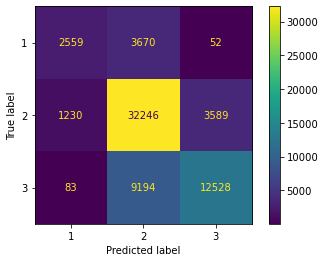

In [35]:
plot_confusion_matrix(knn2_pipe, X_test, y_test);

In [36]:
cm = confusion_matrix(y_test, knn2_preds)
low_damage = cm[0][0] / (cm[0][0] + cm[0][1] + cm[0][2])
medium_damage = cm[1][1] / (cm[1][0] + cm[1][1] + cm[1][2])
complete_destruction = cm[2][2] / (cm[2][0] + cm[2][1] + cm[2][2])
print(f'The model correctly predicts {round(low_damage*100, 2)}% of low damage.')
print(f'The model correctly predicts {round(medium_damage*100, 2)}% of medium damage.')
print(f'The model correctly predicts {round(complete_destruction*100, 2)}% of complete destruction.')

The model correctly predicts 40.74% of low damage.
The model correctly predicts 87.0% of medium damage.
The model correctly predicts 57.45% of complete destruction.


These are comprable to the Random Forest predictions.

### Export the model

In [37]:
with open ('../Models/knn2.pickle', 'wb') as f:
    pickle.dump(knn2_pipe, f, pickle.HIGHEST_PROTOCOL)